In [1]:
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import climtas

import dask.distributed
import tempfile

tmpdir = tempfile.TemporaryDirectory('dask-worker-space')
dask.distributed.Client(local_directory=tmpdir.name, memory_limit='16gb')

In [22]:
tmpdir.name

'/local/w40/ab2313/tmp/tmpl2msnrh4dask-worker-space'

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43315,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://127.0.0.1:37769,Total threads: 1
Dashboard: http://127.0.0.1:41627/status,Memory: 11.23 GiB
Nanny: tcp://127.0.0.1:41475,


In [4]:
DATA_PATH = '/g/data/rt52/era5/single-levels/reanalysis/mtnlwrf'
DATA_PATH

'/g/data/rt52/era5/single-levels/reanalysis/mtnlwrf'

In [31]:
np.sort(os.listdir(DATA_PATH))[-4:]

array(['2019', '2020', '2021', '2022'], dtype='<U4')

In [7]:
files = os.listdir(os.path.join(DATA_PATH, year))
files

['mtnlwrf_era5_oper_sfc_20220101-20220131.nc',
 'mtnlwrf_era5_oper_sfc_20220201-20220228.nc',
 'mtnlwrf_era5_oper_sfc_20220301-20220331.nc']

In [28]:
ds = xr.open_mfdataset(DATA_PATH + '/*/*.nc', chunks = {'latitude': -1, 'longitude': -1, 'time': 33})

In [29]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 379097)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1979-01-01T07:00:00 ... 2022-03-31T23:00:00
Data variables:
    mtnlwrf    (time, latitude, longitude) float32 dask.array<chunksize=(33, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-10-09 14:25:22 UTC+1100 by era5_replication_tools-1.2....
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 single-levels reanalysis mean_top_net_long_wave_radiat...

In [32]:
ds.time.values

array(['1979-01-01T07:00:00.000000000', '1979-01-01T08:00:00.000000000',
       '1979-01-01T09:00:00.000000000', ...,
       '2022-03-31T21:00:00.000000000', '2022-03-31T22:00:00.000000000',
       '2022-03-31T23:00:00.000000000'], dtype='datetime64[ns]')

In [34]:
ds = ds.sel(latitude=slice(-5, -35), longitude=slice(100, 170))

In [35]:
ds = ds.resample(time='D').mean()
ds

<xarray.Dataset>
Dimensions:    (time: 15796, longitude: 281, latitude: 121)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-03-31
  * longitude  (longitude) float32 100.0 100.2 100.5 100.8 ... 169.5 169.8 170.0
  * latitude   (latitude) float32 -5.0 -5.25 -5.5 -5.75 ... -34.5 -34.75 -35.0
Data variables:
    mtnlwrf    (time, latitude, longitude) float32 dask.array<chunksize=(1, 121, 281), meta=np.ndarray>

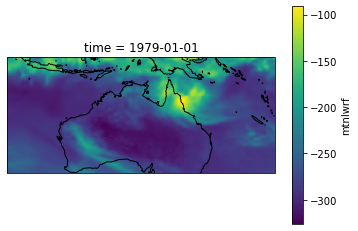

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ds.isel(time=0).mtnlwrf.plot()
ax.coastlines()

In [41]:
help(climtas.io.to_netcdf_throttled)

Help on function to_netcdf_throttled in module climtas.io:

to_netcdf_throttled(ds: Union[xarray.core.dataarray.DataArray, xarray.core.dataset.Dataset], path: Union[str, pathlib.Path], complevel: int = 4, max_tasks: int = None, show_progress: bool = True)
    Save a DataArray to file by calculating each chunk separately (rather than
    submitting the whole Dask graph at once). This may be helpful when chunks
    are large, e.g. doing an operation on dayofyear grouping for a long timeseries.
    
    Chunks are calculated with at most 'max_tasks' chunks running in parallel -
    this defaults to the number of workers in your dask.distributed.Client, or
    is 1 if distributed is not being used.
    
    This is a very basic way to handle backpressure, where data is coming in
    faster than it can be processed and so fills up memory. Ideally this will
    be fixed in Dask itself, see e.g.
    https://github.com/dask/distributed/issues/2602
    
    In particular, it will only work well

In [42]:
climtas.io.to_netcdf_throttled(ds, '/g/data/w40/ab2313/mjo_and_rainfall_trend/era5.mtnlwrf.daily.nc')

  0%|          | 0/15796 [00:00<?, ?it/s]